Long & Short Positions based on MACD hist Divergence

Confirm with SMA200

Take profit and Stop Loss based on higher highs and lower lows in last 10 candles 

Results with S&P500 H1




In [ ]:
!git clone https://github.com/mohammadataei93/Algorithmic-Trading-.git

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib
!pip install zigzag
!pip install --upgrade mplfinance
!pip install yfinance
!pip install git+https://github.com/yhilpisch/tpqoa.git

In [ ]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import datetime
from zigzag import *
import talib as ta
import mplfinance as mpf
from scipy.signal import argrelextrema
import pywt
from statsmodels.robust import mad
import tpqoa
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

## Ethereum H1

In [14]:
# get h1 eth data from google drive and preprocess it
pd_data = pd.read_csv('/content/Algorithmic-Trading-/Data/ETHUSDT(H1).csv')
pd_data = pd_data.drop(['Open','Close'] , axis = 1)
pd_data = pd_data.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close'})
pd_data['Date'] = pd_data['time'].apply(lambda x : datetime.datetime.fromtimestamp(x))
pd_data = pd_data[['Date','Open','High','Low','Close','Volume']]
data = pd_data.copy()
data


,Date,Open,High,Low,Close,Volume
0,2019-01-01 00:00:00,131.45,132.22,131.01,131.82,12677.96176
1,2019-01-01 01:00:00,131.83,131.88,131.00,131.14,9541.84565
2,2019-01-01 02:00:00,131.19,131.34,130.00,130.72,12039.04136
3,2019-01-01 03:00:00,130.72,131.47,130.71,131.32,6320.30743
4,2019-01-01 04:00:00,131.31,134.00,131.30,132.35,29214.64195
...,...,...,...,...,...,...
23736,2021-09-18 11:00:00,3523.24,3536.41,3489.71,3496.50,11867.58800
23737,2021-09-18 12:00:00,3496.51,3518.23,3483.54,3488.48,17310.14510
23738,2021-09-18 13:00:00,3488.25,3507.00,3464.44,3481.50,12975.42900
23739,2021-09-18 14:00:00,3481.33,3492.13,3470.35,3481.20,10199.64770


Backtesting Class

In [34]:
class Backtest():

    def __init__(self,
                 amount = 10000 ,
                 ftc=0.0,
                 ptc=0.0,
                 verbose=True ,
                 argrelextrema_order = 5 ,
                 divergence = 'RSI',
                 sma = None):

        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.argrelextrema_order = argrelextrema_order 
        self.divergence = divergence
        self.sma = sma
        self.data = None
        self.PnL = pd.DataFrame(columns=['Date','pnl'])
        self.open_position = None
        self.positions_info = []


    def add_data(self , data):

      self.data = data.copy()
      self.data.index = self.data['Date']
      self.data['RSI'] = ta.RSI(self.data['Close'])
      self.data['MACD'],self.data['MACD_Signal'],self.data['MACD_Hist'] = ta.MACD(self.data['Close'])
      self.data['ATR'] = ta.ATR(self.data['High'],self.data['Low'],self.data['Close'])
      self.data['slowk'], self.data['slowd'] = ta.STOCH(self.data['High'],self.data['Low'],
                                                        self.data['Close'],fastk_period=5,slowk_period=3,slowd_period=3)
      if self.sma:
        self.sma_key = f'SMA{self.sma}'
        self.data[self.sma_key] = ta.SMA(self.data['Close'],self.sma)
      self.data.dropna(inplace = True)


    def plot_data(self, cols='Close'):
        ''' Plots the closing prices for symbol.
        '''
        self.data[cols].plot(figsize=(10, 6))

    def get_date_price(self, bar , priceindex = 'Close'):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])
        price = self.data[priceindex].iloc[bar]
        # self.data['positions'] = np.nan
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')

    def calculate_asset(self,bar):
        date, price = self.get_date_price(bar)
        self.asset = self.units * price + self.amount
        return self.asset

    def calculate_PnL(self,dates,pnl,show = True):
        self.PnL['Date'] = dates
        self.PnL['pnl'] = pnl
        self.PnL.index = self.PnL['Date']
        self.PnL['pnl'].plot(figsize=(10, 6))

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = np.round(amount / price ,4)
        self.amount -= (units * price) 
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = np.round(amount / price ,4)
        self.amount += (units * price) 
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        self.trades += 1
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        count ,avg_win , avg_lose = 0,0,0
        for pos in self.positions_info:
          if pos['Profit'] > 0 :
            count += 1
            avg_win += pos['Profit']
          if pos['Profit'] < 0 :
            avg_lose += pos['Profit']

        self.accuracy = count / len(self.positions_info)
        print('Net Performance [%] {:.2f}'.format(perf))
        print('Trades Executed [#] {}'.format(len(self.positions_info)))
        print('Accuracy        [%] {:.2f}'.format(self.accuracy * 100))
        print('Avg Win/Avg Lose   {:.2f}'.format( np.abs(avg_win / avg_lose)) )
        print('=' * 55)


    def go_long(self, bar, units=None, amount=None):
        if units:
            self.place_buy_order(bar, units=units)
        elif amount:
            self.place_buy_order(bar, amount=amount)

    def go_short(self, bar, units=None, amount=None):
        if units:
            self.place_sell_order(bar, units=units)
        elif amount:
            self.place_sell_order(bar, amount=amount)


    def divergence_detector(self, data):
      divergence = None
      peak = None
      # price_data_h = data['High'].values
      # price_data_l = data['Low'].values
      price_data = data['Close'].values
      highs = argrelextrema(price_data , np.greater_equal, order=self.argrelextrema_order)[0]
      lows = argrelextrema(price_data , np.less_equal, order=self.argrelextrema_order)[0]
      if highs[-1] > lows[-1]:
        peak = 'High'
        current_peak_idx = highs[-1]
        previous_peak_idx = highs[-2]
        reverse_peak_idx = lows[-1]
      else :
        peak = 'Low'
        current_peak_idx = lows[-1]
        previous_peak_idx = lows[-2]
        reverse_peak_idx = highs[-1]

      peak1 = data['Date'][current_peak_idx]
      peak2 = data['Date'][previous_peak_idx]
      peak_reverse = data['Date'][reverse_peak_idx]


      # price_h = data['High'].values
      # price_l = data['Low'].values
      price = data['Close'].values
      indicator = data[self.divergence].values

      if peak == 'High':
        if price[current_peak_idx] > price[previous_peak_idx] and indicator[current_peak_idx] < indicator[previous_peak_idx] and \
                  data['MACD_Hist'][current_peak_idx] > 0 and data['MACD_Hist'][previous_peak_idx] > 0: 
          divergence = 'Bearish'
      if peak == 'Low':
        if price[current_peak_idx] < price[previous_peak_idx] and indicator[current_peak_idx] > indicator[previous_peak_idx] and \
                  data['MACD_Hist'][current_peak_idx] < 0 and data['MACD_Hist'][previous_peak_idx] < 0:
          divergence = 'Bullish'

      return divergence , peak1 , peak2 , peak_reverse 


    def run(self , window , found_risk = 0.02):
        msg = f'\n\nRunning MACD Divergence strategy'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0
        self.trades = 0 
        self.amount = self.initial_amount 
        self.window = window
        self.found_risk = found_risk
        self.state = 'Wait For Signal'
        self.observed_divergence = None
        self.data['long_position'] = np.nan
        self.data['short_position'] = np.nan
        self.peak1 ,self.peak2 = None,None
        dates,pnl = [],[]
        position_id = 0
        counter = 0
        for bar in range(self.window , len(self.data)):

          data = self.data[bar - self.window : bar]
          
          if self.position != 0: self.follow_positions(bar)
          else:

            if self.state == 'Wait For Signal':
              divergence,peak1,peak2,peak_reverse = self.divergence_detector(data)
              if divergence:
                counter +=1
                self.observed_divergence = divergence
                self.peak1,self.peak2,self.peak_reverse  = peak1,peak2,peak_reverse 
                self.state = 'Wait For Confirmation'


            if self.state == 'Wait For Confirmation':

              if self.data['Close'][bar-1] > self.data[self.sma_key][bar-1] and self.observed_divergence == 'Bullish': 
                self.position = 'Long'
                sl,tp = self.place_sl_tp(bar)
                if 1:
                  self.data['long_position'][bar] = 1 
                  date , entering_price = self.get_date_price(bar)
                  position_id += 1
                  print(f'{date} | Stop Loss: {sl:.2f} | Take Profit : {tp:.02f}')
                  self.open_position = {'position_id':position_id,'Index':bar,'Date':date,
                                              'Position':'Long','EnteringPrice':entering_price,
                                              'StopLoss':sl,'TakeProfit':tp,'Peak1':peak1,'Peak2':peak2,
                                              'Profit':None}
                  
                  self.go_long(bar, amount= self.amount * self.found_risk)
                  self.state = 'Wait For Signal'
                  if self.verbose:
                    print(f'{date} | @@@@@ Long Order Executed @@@@@')
                else: self.position = 0

              elif self.data['Close'][bar-1] < self.data[self.sma_key][bar-1] and self.observed_divergence == 'Bearish':
                self.position = 'Short' 
                sl,tp = self.place_sl_tp(bar)
                if 1:
                  date , entering_price = self.get_date_price(bar)
                  self.data['short_position'][bar] = -1 
                  position_id += 1
                  print(f'{date} | Stop Loss: {sl:.2f} | Take Profit : {tp:.02f}')
                  self.open_position = {'position_id':position_id,'Index':bar,'Date':date,
                                              'Position':'Short','EnteringPrice':entering_price,
                                              'StopLoss':sl,'TakeProfit':tp,'Peak1':peak1,'Peak2':peak2,
                                              'Profit':None}
                  self.go_short(bar, amount=self.amount * self.found_risk)
                  self.state = 'Wait For Signal'
                  if self.verbose:
                    print(f'{date} | @@@@@ Short Order Executed @@@@@')
                else: self.position = 0

              else :
                counter += 1

              if counter > 4 :
                counter = 0
                self.state= 'Wait For Signal'


          date , price = self.get_date_price(bar)
          dates.append(date)
          pnl.append(self.calculate_asset(bar))

        self.close_out(bar)
        self.calculate_PnL(dates , pnl)


    def place_sl_tp(self , bar):
      sl,tp = None,None
      lower_low = min([self.data['Low'][x] for x in range(bar-10,bar)])
      higher_high = max([self.data['High'][x] for x in range(bar-10,bar) ])
      if self.position == 'Long':
        # last_low = self.data.loc[self.peak1]['Low']
        # last_high = self.data.loc[self.peak_reverse]['High']
        sl = (lower_low - 0.1*self.data['ATR'].iloc[bar-1])
        tp = (higher_high - 0.1*self.data['ATR'].iloc[bar-1])
      if self.position == 'Short':
        # last_high = self.data.loc[self.peak1]['High']
        # last_low = self.data.loc[self.peak_reverse]['Low']
        sl = (higher_high + 0.1*self.data['ATR'].iloc[bar-1])
        tp = (lower_low + 0.1*self.data['ATR'].iloc[bar-1])
      return sl,tp


    def follow_positions(self , bar):
      date , highprice = self.get_date_price(bar,priceindex ='High')
      date , lowprice = self.get_date_price(bar,priceindex ='Low')

      if self.open_position['Position'] == 'Long':

        if lowprice < self.open_position['StopLoss']:
          self.place_sell_order(bar, units=self.units)
          loss = self.open_position['EnteringPrice'] - self.open_position['StopLoss']
          self.open_position['Profit'] = -loss
          self.open_position['CloseDate'] = date
          price = self.open_position['StopLoss']
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0 
          if self.verbose:
            print(f'{date} | !!! StopLoss Activated at {price:.2f} !!!')       
            print(f'{date} | Long Position Closed with {loss:.2f} Loss :((( ')
            print('=' * 55)  
            return  

        if highprice > self.open_position['TakeProfit']:
          self.place_sell_order(bar, units=self.units)
          profit = self.open_position['TakeProfit'] - self.open_position['EnteringPrice']
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          price = self.open_position['TakeProfit']
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          if self.verbose:
            print(f'{date} | $$$ Take Profit Activated at {price:.2f} $$$')       
            print(f'{date} | Long Position Closed with {profit:.2f} Profit :)))')  
            print('=' * 55)
          return

      if self.open_position['Position'] == 'Short':

        if highprice > self.open_position['StopLoss']:
          self.place_buy_order(bar, units=-self.units)
          loss = self.open_position['StopLoss'] - self.open_position['EnteringPrice']
          self.open_position['Profit'] = -loss
          self.open_position['CloseDate'] = date
          price = self.open_position['StopLoss']
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          if self.verbose:
            print(f'{date} | !!! StopLoss Activated at {price:.2f} !!!')       
            print(f'{date} | Short Position Closed  with {loss:.2f} Loss :((( ')
            print('=' * 55)  
          return

        if lowprice < self.open_position['TakeProfit']:
          self.place_buy_order(bar, units=-self.units)  
          profit = self.open_position['EnteringPrice'] - self.open_position['TakeProfit']
          self.open_position['Profit'] = profit
          self.open_position['CloseDate'] = date
          price = self.open_position['TakeProfit']
          self.positions_info.append(self.open_position)
          self.open_position = None
          self.position = 0
          if self.verbose:
            print(f'{date} | $$$ take profit activated at {price:.2f} $$$')       
            print(f'{date} | Short Position Closed  with {profit:.2f} Profit :)))') 
            print('=' * 55)
          return
      

    def illustrate_position(self,idx,forward_candles = 100):
      time_idx = self.positions_info[idx]['Index']
      position = self.positions_info[idx]['Position']
      date = self.positions_info[idx]['Date']
      stoploss = self.positions_info[idx]['StopLoss']
      takeprofit = self.positions_info[idx]['TakeProfit']
      profit = self.positions_info[idx]['Profit']
      id = self.positions_info[idx]['position_id']
      closedate = self.positions_info[idx]['CloseDate']
      peak1 = self.positions_info[idx]['Peak1']
      peak2 = self.positions_info[idx]['Peak2']

      print('=' * 55) 
      print(f'{date} |{position} Order Executed | ID:{id}')
      print(f'{closedate} |Profit : {profit:0.2f} ')
      print('=' * 55)

      data1 = self.data[time_idx-self.window:time_idx]
      data2 = self.data[time_idx:time_idx+forward_candles]
      data = pd.DataFrame()
      dataclose = data1['Close'].values
      highs = argrelextrema(dataclose, np.greater_equal, order=self.argrelextrema_order)[0]
      lows = argrelextrema(dataclose, np.less_equal, order=self.argrelextrema_order)[0]
      peaks = [np.nan]*len(data1)
      peaks_ind = [np.nan]*len(data1)
      for h in highs:
        peaks[h] = data1['Close'][h]
        peaks_ind[h] = data1['MACD_Hist'][h]
      for l in lows:
        peaks[l] = data1['Close'][l]
        peaks_ind[l] = data1['MACD_Hist'][l]

      data1['pivots'] = peaks
      data1['pivots_ind'] = peaks_ind
      data1['stoploss'],data1['takeprofit'] = np.nan , np.nan
      data2['stoploss'] = stoploss
      data2['takeprofit'] = takeprofit
      data2['pivots'] = np.nan
      data2['pivots_ind'] = np.nan
      data = pd.concat([data1,data2])
      data['signal'] = np.nan
      data['signal'][self.window] = data['Close'][self.window] 

      

      if self.positions_info[idx]['Position'] == 'Long':
        two_points = [( str(peak1) , float(data[data['Date'] == peak1]['Low'])),( str(peak2), float(data[data['Date'] == peak2]['Low']))]
      if self.positions_info[idx]['Position'] == 'Short':
        two_points = [( str(peak1) , float(data[data['Date'] == peak1]['High'])),( str(peak2), float(data[data['Date'] == peak2]['High']))]
      

      # macd panel
      ticker_name = 'ETH'
      colors = ['g' if v >= 0 else 'r' for v in data["MACD_Hist"]]
      macd_plot = mpf.make_addplot(data["MACD"], panel=1, color='fuchsia', title="MACD" )
      macd_hist_plot = mpf.make_addplot(data["MACD_Hist"], type='bar', panel=1, color=colors) # color='dimgray'
      macd_hist_plot_pivot = mpf.make_addplot(data["pivots_ind"],type='scatter',markersize=10,marker='o' , panel=1 , color='black')
      macd_signal_plot = mpf.make_addplot(data["MACD_Signal"], panel=1, color='b')
      if position == 'Long':
        signal_plot = mpf.make_addplot(data['signal'],type='scatter',markersize=150,marker='^' , panel=0)
      if position == 'Short':
        signal_plot = mpf.make_addplot(data['signal'],type='scatter',markersize=150,marker='v' , panel=0)
      pivot_plot = mpf.make_addplot(data['pivots'],type='scatter',markersize=10, marker='o' , panel=0 , color='black')
      # rsi_plot =  mpf.make_addplot(data['RSI'], panel=2, color='blue', title="RSI" )
      sma_plot =  mpf.make_addplot(data[self.sma_key], panel=0, color='blue', title="SMA" )
      SL = mpf.make_addplot(data['stoploss'] ,panel=0,color='red')
      TP = mpf.make_addplot(data['takeprofit'] ,panel=0,color='green')

      plots = [signal_plot,pivot_plot,sma_plot,SL,TP,macd_plot,macd_hist_plot,macd_signal_plot,macd_hist_plot_pivot]
      mpf.plot(data ,
               type='candle',
               style='yahoo',
               figsize = (15,10) ,
               alines=[two_points,two_points] ,
               vlines=dict(vlines= [str(peak1),str(peak2)],linestyle='--', linewidths = (0.5,0.5) ),
               volume=False,
               volume_panel=3,
               addplot=plots, 
               title=f"\n{ticker_name}",
               ylabel='',
               ylabel_lower='')
      print(' ')
      print(' ')

    def plot(self):
      long_position_plot = mpf.make_addplot(self.data['long_position'],type='scatter',markersize=50,marker='o' , panel=0 , color = 'green' )
      short_position_plot = mpf.make_addplot(self.data['short_position'],type='scatter',markersize=50,marker='o' , panel=0 , color = 'red')
      plots = [long_position_plot,short_position_plot]
      
      mpf.plot(self.data ,
                type='candle',
                style='yahoo',
                figsize = (30,20) ,
                addplot=plots, 
                title=f"\nAll Data",
                ylabel='',
                ylabel_lower='')




Running MACD Divergence strategy
fixed costs 0.0 | proportional costs 0.0
2019-01-15 01:00:00 | Stop Loss: 130.25 | Take Profit : 115.52
2019-01-15 01:00:00 | selling 78.5238 units at 127.35
2019-01-15 01:00:00 | current balance 20000.01
2019-01-15 01:00:00 | current net wealth 10000.00
2019-01-15 01:00:00 | @@@@@ Short Order Executed @@@@@
2019-01-21 04:00:00 | buying 78.5238 units at 114.79
2019-01-21 04:00:00 | current balance 10986.26
2019-01-21 04:00:00 | current net wealth 10986.26
2019-01-21 04:00:00 | $$$ take profit activated at 115.52 $$$
2019-01-21 04:00:00 | Short Position Closed  with 11.83 Profit :)))
2019-01-23 03:00:00 | Stop Loss: 119.60 | Take Profit : 117.39
2019-01-23 03:00:00 | selling 92.8835 units at 118.28
2019-01-23 03:00:00 | current balance 21972.52
2019-01-23 03:00:00 | current net wealth 10986.26
2019-01-23 03:00:00 | @@@@@ Short Order Executed @@@@@
2019-01-23 08:00:00 | buying 92.8835 units at 117.60
2019-01-23 08:00:00 | current balance 11049.42
2019-0

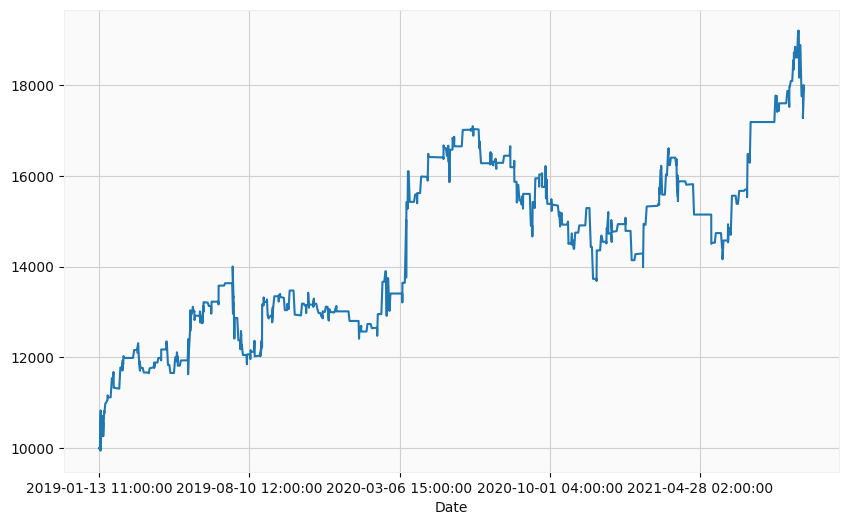

In [35]:
bt = Backtest(verbose=True,
              amount=10000,
              sma=200,
              divergence = 'MACD_Hist')
bt.add_data(data)
bt.run(window = 100 , found_risk = 1 )

In [ ]:
bt.plot()

2019-08-06 23:00:00 |Long Order Executed | ID:65
2019-08-07 13:00:00 |Profit : 4.32 


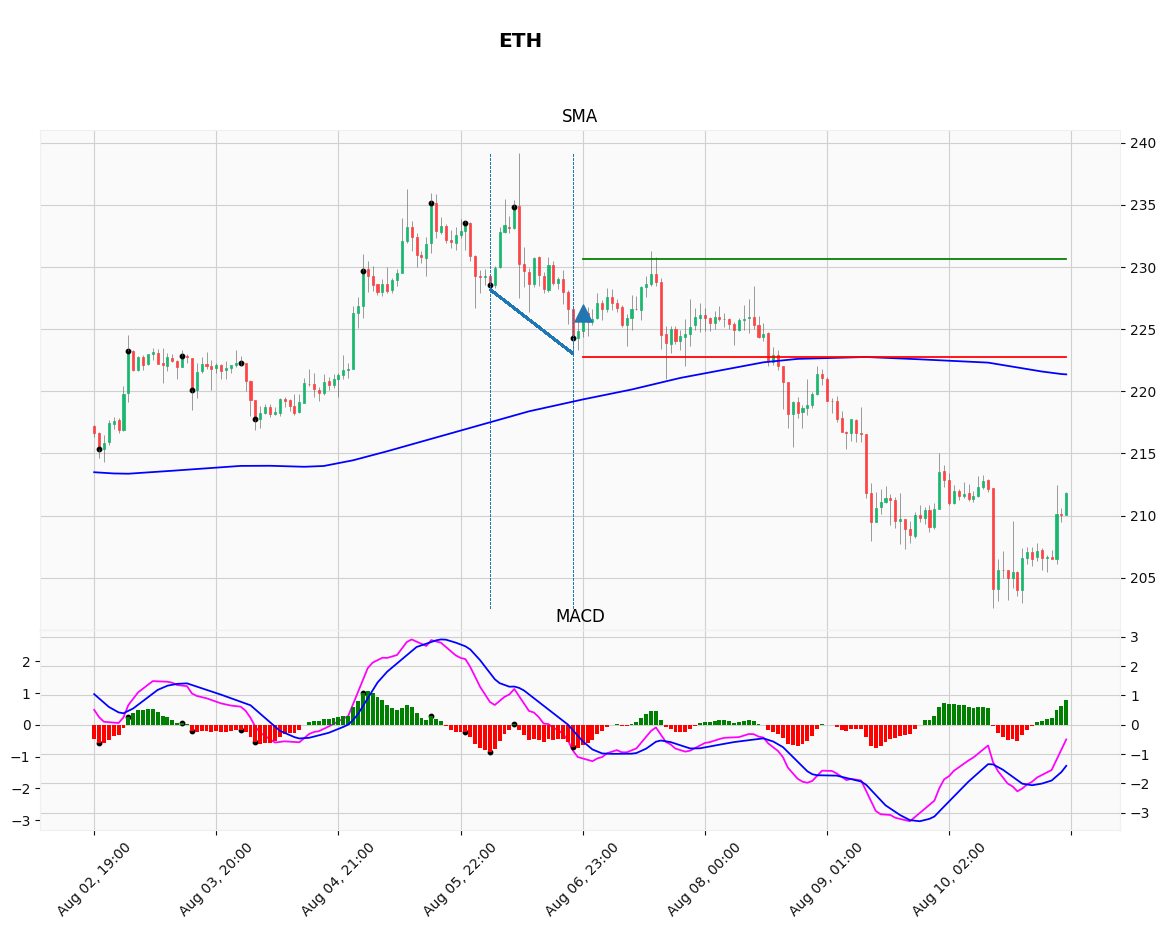

In [41]:
def show_positions(num_sample = 1):
  for i in range(num_sample):
    index = np.random.randint(0,len(bt.positions_info))
    bt.illustrate_position(index)

show_positions()